In [1]:
#download libraries if not already installed
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
except ImportError:
    import os
    os.system('pip install numpy matplotlib')

try:
    import keras
    from keras.models import resnet
except ImportError:
    import os
    os.system(' pip install keras-resnet ')

try:
    import tensorflow as tf
except ImportError:
    import os
    os.system('pip install tensorflow')

# preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#Plot the animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
pos=np.load('data_npy/100_3.npy')
vid=np.load('data_video/100_3.npy')
midline=np.load('data_midline/100_3_consistent.npy')
velocity =midline[1:,:,1,:]-midline[:-1,:,1,:]
head=midline[:,:,0,:]-midline[:,:,1,:]
tail=midline[:,:,2,:]-midline[:,:,1,:]

phi= np.arctan2(head[:,:,1], head[:,:,0])
# angular_speed= angle_between_2vec(head[1:,:,:], head[:-1,:,:], axis=2) 
L1=np.linalg.norm(head, axis=2)
L2=np.linalg.norm(tail, axis=2)
Observer_index=0
R=500
Observed_vector=midline[:,None,:,1,:]-midline[:,:,None,1,:]
Observed_distance=np.linalg.norm(Observed_vector, axis=3)
# Observed_phi=angle_between_2vec(head[:,:,None,:], Observed_vector, axis=3)
Observed_index=Observed_distance<=R

## getting observation

In [3]:
#get shape of midline
print("midline.shape:", midline.shape)

# initialize the observation map
grid_size = 64
N = midline.shape[1]
T = midline.shape[0]
boundaries_radius = 3500/2
def initialize_observation_maps_allFrame(N, T, grid_size):
    # Initialize the observation maps for all frames
    obs_maps = np.zeros((T, N, 4, grid_size, grid_size))
    return obs_maps
def initialize_observation_maps(N, grid_size):
    # Initialize the observation maps in a single frame
    obs_maps = np.zeros((N, 4, grid_size, grid_size))
    return obs_maps

# initialize the observation maps for all frames for training
obs_maps = initialize_observation_maps_allFrame(N, T, grid_size)
print("obs_maps.shape:", obs_maps.shape)

# test observation maps for a single frame (e.g., frame 0)
obs_maps_single_frame = initialize_observation_maps(N, grid_size)
print("obs_maps_single_frame.shape:", obs_maps_single_frame.shape)

midline.shape: (19526, 100, 3, 2)
obs_maps.shape: (19526, 100, 4, 64, 64)
obs_maps_single_frame.shape: (100, 4, 64, 64)


### observe other fish

In [4]:
def get_observed_fish_singleFrame(midline, R, obs_maps_singleFrame):
    # assume here midline.shape = (N, 3, 2)
    grid_size = obs_maps_singleFrame.shape[2]
    N = obs_maps_singleFrame.shape[0]  # assume obs_maps_singleFrame.shape[0] = N
    
    #shape of obs_vector: (N,N,3,2)
    obs_vector = np.zeros((N, N, 3, 2), dtype=np.float32)
    #first dimension is the observer
    #second dimension is the observed fish, for each observed, we calculate the vector from (head, tail, center) of the observed fish to the observer's head
    obs_vector[:, :, [0, 1, 2], :] = midline[:,None, [0, 0, 0], :] - midline[None, :, [0, 1, 2], :]

    # get the distance and angle
    obs_distance = np.linalg.norm(obs_vector, axis=3)  # shape: (N, N, 3)
    obs_phi = np.arctan2(obs_vector[:, :, :, 1], obs_vector[:, :, :, 0])  # shape: (N, N, 3)


    # check if the distance is within the radius R
    obs_index = obs_distance <= R
    # if within the radius, digitize the distance and angle with grid_size and put the value in the observation map
    obs_distance_digitized = np.clip((obs_distance / R) * grid_size, 0, grid_size - 1).astype(int)
    obs_phi_digitized = np.clip((obs_phi + np.pi) / (2 * np.pi) * grid_size, 0, grid_size - 1).astype(int)
    # fill the observation map
    # Broadcasting version: update obs_maps_singleFrame for all valid observations at once
    # obs_index shape: (N, N, 3)
    idx = np.where(obs_index)
    #print("idx:", idx)  # idx will have three arrays: one for each dimension
    # idx[0] is the observer index, idx[1] is the observed fish, idx[2] is the body part (head, tail, center)
    obs_maps_singleFrame[idx[0], idx[2], obs_distance_digitized[idx], obs_phi_digitized[idx]] = 1
    return obs_maps_singleFrame

def get_observed_fish_allFrame(midline, R, obs_maps):
    """ #output: obs_maps.shape = (T, N, 4, grid_size, grid_size)
    # assume here midline.shape = (T, N, 3, 2)
    grid_size = obs_maps.shape[3]
    N = obs_maps.shape[1] #assume obs_maps.shape[1] = N
    T = obs_maps.shape[0] #assume obs_maps.shape[0] = T
    
    #shape of obs_vector: (T, N, N, 3, 2)
    obs_vector = np.zeros((T, N, N, 3, 2), dtype=np.float32)
    obs_vector[:, :, :, [0, 1, 2], :] = midline[:, :, None, [0, 0, 0], :] - midline[:, None, :, [0, 1, 2], :]

    # get the distance and angle
    obs_distance = np.linalg.norm(obs_vector, axis=4)  # shape: (T, N, N, 3)
    obs_phi = np.arctan2(obs_vector[:, :, :, :, 1], obs_vector[:, :, :, :, 0])  # shape: (T, N, N, 3)
    # check if the distance is within the radius R
    obs_index = obs_distance <= R
    # if within the radius, digitize the distance and angle with grid_size and put the value in the observation map
    obs_distance_digitized = np.clip((obs_distance / R) * grid_size, 0, grid_size - 1).astype(int)
    obs_phi_digitized = np.clip((obs_phi + np.pi) / (2 * np.pi) * grid_size, 0, grid_size - 1).astype(int)
    # fill the observation map
    # Broadcasting version: update obs_maps for all valid observations at once
    idx = np.where(obs_index)
    #print("idx:", idx)  # idx will have three arrays: one for each dimension
    # idx[0] is the time index, idx[1] is the observer index, idx[2] is the observed fish, idx[3] is the body part (head, tail, center)
    obs_maps[idx[0], idx[1], idx[3], obs_distance_digitized[idx], obs_phi_digitized[idx]] = 1    """
    #above code may use too many RAM due to large boardcasting
    #use a slower version:
    T = obs_maps.shape[0] #assume obs_maps.shape[0] = T
    for t in tqdm(range(T)):
        obs_maps[t] = get_observed_fish_singleFrame(midline[t], R, obs_maps[t])

    return obs_maps

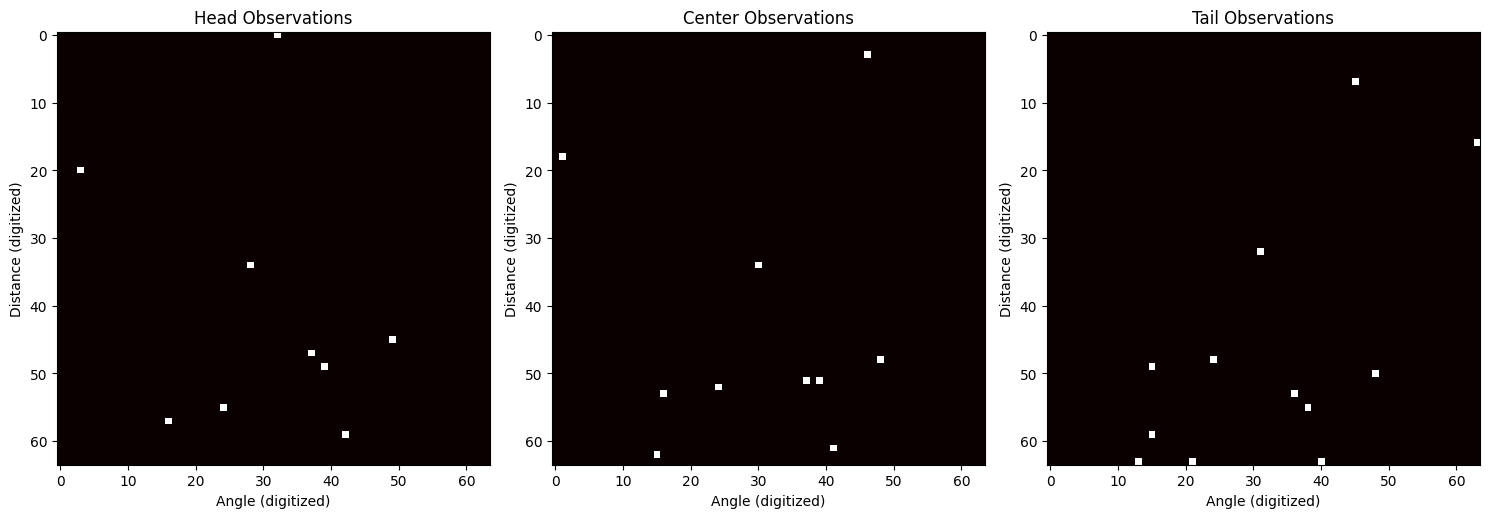

obs_maps_singleFrame_stacked.shape: (100, 64, 64)


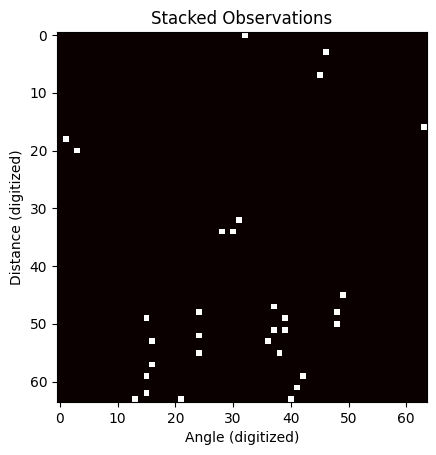

: 

In [ ]:
# Test get_observed_fish_singleFrame
obs_maps_singleFrame = get_observed_fish_singleFrame(midline[0], R, obs_maps_single_frame)

# Plot the observation map for the first frame of index 10 as observer
# 3 sub-figures need to be plotted: head, tail, center into 1 plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Head Observations
axes[0].imshow(obs_maps_singleFrame[10, 0, :, :], cmap='hot', interpolation='nearest')
axes[0].set_title('Head Observations')
axes[0].set_xlabel('Angle (digitized)')
axes[0].set_ylabel('Distance (digitized)')

# Center Observations
axes[1].imshow(obs_maps_singleFrame[10, 1, :, :], cmap='hot', interpolation='nearest')
axes[1].set_title('Center Observations')
axes[1].set_xlabel('Angle (digitized)')
axes[1].set_ylabel('Distance (digitized)')

# Tail Observations
axes[2].imshow(obs_maps_singleFrame[10, 2, :, :], cmap='hot', interpolation='nearest')
axes[2].set_title('Tail Observations')
axes[2].set_xlabel('Angle (digitized)')
axes[2].set_ylabel('Distance (digitized)')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Stack the 3 observation maps into one
obs_maps_singleFrame_stacked = np.sum(obs_maps_singleFrame, axis=1)
obs_maps_singleFrame_stacked = np.where(obs_maps_singleFrame_stacked > 1, 1, obs_maps_singleFrame_stacked)  # Binarize the stacked map
print("obs_maps_singleFrame_stacked.shape:", obs_maps_singleFrame_stacked.shape)

# Plot the stacked observation map
plt.imshow(obs_maps_singleFrame_stacked[10], cmap='hot', interpolation='nearest')
plt.title('Stacked Observations')
plt.xlabel('Angle (digitized)')
plt.ylabel('Distance (digitized)')
plt.show()

In [ ]:
#test the function for all frames
obs_maps = get_observed_fish_allFrame(midline, R, obs_maps)
# Plot the observation map for the first frame of index 10 as observer
# 3 sub-figures need to be plotted: head, tail, center into 1 plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Head Observations
axes[0].imshow(obs_maps[0,10, 0, :, :], cmap='hot', interpolation='nearest')
axes[0].set_title('Head Observations')
axes[0].set_xlabel('Angle (digitized)')
axes[0].set_ylabel('Distance (digitized)')  
# Center Observations
axes[1].imshow(obs_maps[0,10, 1, :, :], cmap='hot', interpolation='nearest')
axes[1].set_title('Center Observations')
axes[1].set_xlabel('Angle (digitized)')
axes[1].set_ylabel('Distance (digitized)')
# Tail Observations
axes[2].imshow(obs_maps[0,10, 2, :, :], cmap='hot', interpolation='nearest')
axes[2].set_title('Tail Observations')
axes[2].set_xlabel('Angle (digitized)')
axes[2].set_ylabel('Distance (digitized)')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#stack the 3 observation maps into one
obs_maps_stacked = np.sum(obs_maps, axis=1)
obs_maps_stacked = np.where(obs_maps_stacked > 1, 1, obs_maps_stacked)  # Binarize the stacked map
print("obs_maps_stacked.shape:", obs_maps_stacked.shape)    
# Plot the stacked observation map
plt.imshow(obs_maps_stacked[0,10], cmap='hot', interpolation='nearest')
plt.title('Stacked Observations')
plt.xlabel('Angle (digitized)')
plt.ylabel('Distance (digitized)')
plt.show()

  0%|          | 0/19526 [00:00<?, ?it/s]

 15%|█▍        | 2902/19526 [00:05<00:28, 589.44it/s]

### observe boundaries

## prepare data

# training

## model structure

## train